In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rockpaperscissors/README_rpc-cv-images.txt
/kaggle/input/rockpaperscissors/paper/cQ0dBO3yHPohZ9U9.png
/kaggle/input/rockpaperscissors/paper/jAh36hlZLpECSBHp.png
/kaggle/input/rockpaperscissors/paper/QnjBVl6cFnyd2hVF.png
/kaggle/input/rockpaperscissors/paper/dZh2VMRu9nRGHhYL.png
/kaggle/input/rockpaperscissors/paper/SDQQfzHl47yNqA6K.png
/kaggle/input/rockpaperscissors/paper/E10FR2TKbBsv9Hgm.png
/kaggle/input/rockpaperscissors/paper/BoMfAmQYWtoiGHBV.png
/kaggle/input/rockpaperscissors/paper/AfvIbTwxuG0q7Ij1.png
/kaggle/input/rockpaperscissors/paper/41HC0VBlHSRhi0AG.png
/kaggle/input/rockpaperscissors/paper/gpipGA62xfMjfr8O.png
/kaggle/input/rockpaperscissors/paper/9rwmakEj6Wg1YQWW.png
/kaggle/input/rockpaperscissors/paper/D3mbFhVy7zFkZEtV.png
/kaggle/input/rockpaperscissors/paper/cuDzhxpWujBPgJmX.png
/kaggle/input/rockpaperscissors/paper/5FVy5hSvZ9c0M2Y5.png
/kaggle/input/rockpaperscissors/paper/4aWP3XumkgwZtqZ7.png
/kaggle/input/rockpaperscissors/paper/aac4C8FFlVQw6aGM.png

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from tensorflow.keras.layers import RandomFlip,RandomRotation,RandomZoom,RandomContrast,RandomTranslation,Dropout,Dense,Conv2D,MaxPooling2D,Input
from tensorflow.keras.activations import relu,softmax
from tensorflow.keras.optimizers import RMSprop

2025-07-23 02:38:04.763343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753238285.004977      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753238285.077081      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
BASE_DIR='/kaggle/input/rockpaperscissors'

In [4]:


import os
import shutil

# Create a new clean folder
clean_dir = 'clean_rps'
os.makedirs(clean_dir, exist_ok=True)

# Copy only the required folders
for class_name in ['rock', 'paper', 'scissors']:
    src = os.path.join(BASE_DIR, class_name)
    dst = os.path.join(clean_dir, class_name)
    shutil.copytree(src, dst, dirs_exist_ok=True)



In [5]:
train_dataset=tf.keras.utils.image_dataset_from_directory(
    'clean_rps',
    image_size=(150,150),
    batch_size=32,
    validation_split=0.1,
    seed=42,
    subset='training',
    
)

validation_dataset=tf.keras.utils.image_dataset_from_directory(
    'clean_rps',
    image_size=(150,150),
    batch_size=32,
    validation_split=0.1,
    seed=42,
    subset='validation'
)

Found 2188 files belonging to 3 classes.
Using 1970 files for training.


I0000 00:00:1753238306.975733      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 2188 files belonging to 3 classes.
Using 218 files for validation.


In [6]:
from tensorflow.keras.applications import EfficientNetB0
pre_trained_model=EfficientNetB0(weights='imagenet',include_top=False,input_shape=(150,150,3))

for layer in pre_trained_model.layers:
    layer.trainable=False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
pre_trained_model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 150, 150,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 150, 150,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 151, 151,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 75, 75,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 75, 75,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 75, 75,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 75, 75,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 75, 75,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 75, 75,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 75, 75,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 75, 75,    │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [8]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
x=pre_trained_model.output
x=Flatten()(x)
x=Dense(1024,activation='relu')(x)
x=Dropout(0.5)(x)
x=Dense(3,activation='softmax')(x)

model=Model(pre_trained_model.input,x)

In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 150, 150,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 150, 150,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 151, 151,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 75, 75,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 75, 75,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 75, 75,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 75, 75,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 75, 75,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 75, 75,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 75, 75,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 75, 75,    │        512 │ block1a_se_excit

 Total params: 36,821,670 (140.46 MB)

 Trainable params: 32,772,099 (125.02 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [10]:
from tensorflow.keras.models import Sequential
data_augmentation=Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.4),
    RandomTranslation(0.2,0.2),
    RandomContrast(0.4),
    RandomZoom(0.2)
    
])

In [11]:
inputs=Input(shape=(150,150,3))
x=data_augmentation(inputs)
x=model(x)

In [12]:
model_with_aug=Model(inputs,x)

In [13]:
model_with_aug.compile(optimizer='rmsprop',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])


In [14]:
def preprocess(image,label):
    image=tf.keras.applications.efficientnet.preprocess_input(image)
    return image,label

In [15]:
train_dataset_scaled=train_dataset.map(preprocess)
validation_dataset_scaled=validation_dataset.map(preprocess)

In [16]:
SHUFFLE_BUFFER_SIZE=1000
PREFETCH_BUFFER_SIZE=tf.data.AUTOTUNE
train_dataset_final=(train_dataset_scaled.cache()
                    .shuffle(SHUFFLE_BUFFER_SIZE)
                    .prefetch(PREFETCH_BUFFER_SIZE))

validation_dataset_final=(validation_dataset_scaled.cache()
                         .prefetch(PREFETCH_BUFFER_SIZE))

In [17]:
history=model_with_aug.fit(
    train_dataset_final,
    epochs=35,
    validation_data=validation_dataset_final,
    verbose=2
)

Epoch 1/35


E0000 00:00:1753238328.004154      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/functional_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1753238331.787734      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


62/62 - 27s - 430ms/step - accuracy: 0.8553 - loss: 2.7948 - val_accuracy: 0.9220 - val_loss: 0.9822
Epoch 2/35
62/62 - 2s - 35ms/step - accuracy: 0.9142 - loss: 1.1660 - val_accuracy: 0.9633 - val_loss: 0.5101
Epoch 3/35
62/62 - 2s - 35ms/step - accuracy: 0.9492 - loss: 0.5928 - val_accuracy: 0.9587 - val_loss: 0.4905
Epoch 4/35
62/62 - 2s - 35ms/step - accuracy: 0.9508 - loss: 0.6215 - val_accuracy: 0.9266 - val_loss: 1.1449
Epoch 5/35
62/62 - 2s - 35ms/step - accuracy: 0.9558 - loss: 0.5590 - val_accuracy: 0.9495 - val_loss: 0.9079
Epoch 6/35
62/62 - 2s - 35ms/step - accuracy: 0.9655 - loss: 0.4981 - val_accuracy: 0.9771 - val_loss: 0.6141
Epoch 7/35
62/62 - 2s - 35ms/step - accuracy: 0.9650 - loss: 0.4490 - val_accuracy: 0.9862 - val_loss: 0.3307
Epoch 8/35
62/62 - 2s - 35ms/step - accuracy: 0.9726 - loss: 0.3593 - val_accuracy: 0.9908 - val_loss: 0.1520
Epoch 9/35
62/62 - 2s - 35ms/step - accuracy: 0.9665 - loss: 0.4823 - val_accuracy: 0.9908 - val_loss: 0.1119
Epoch 10/35
62/62 -

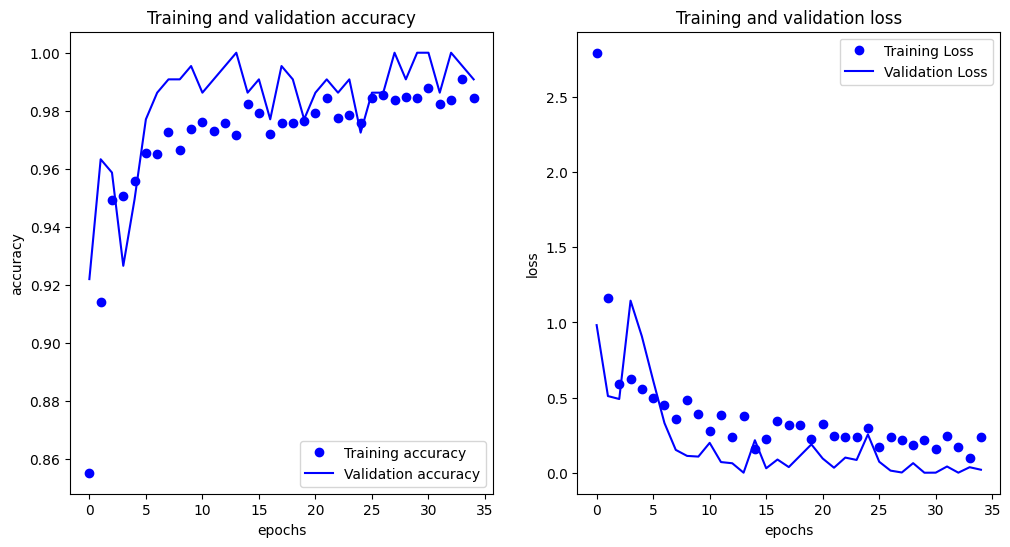

In [18]:


def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()
    
    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()
    
    plt.show()

plot_loss_acc(history)

